In [35]:
import xarray as xr
from data_hunter_era5 import DataRetriver
import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
# global observed data

global_observed_data = DataRetriver.retrive_custom_data(
    startDate='2019-11-25',
    endDate='2019-11-28',
    properties= ['10m_u_component_of_wind', '10m_v_component_of_wind','2m_temperature','surface_pressure'],
    long_min = 43, 
    long_max = 46, 
    lat_min= 38.5,
    lat_max= 41)

# global_observed_data[0]
# global_observed_data[0] = kelvin_to_celsius(global_observed_data[0])
longitude_value = 44.51420518337152
latitude_value = 40.18315899637762

localized_data = xr.merge(global_observed_data).sel(longitude=longitude_value, latitude=latitude_value, method='nearest')
localized_data = localized_data.drop_vars("longitude")
localized_data = localized_data.drop_vars("latitude")

# global_observed_data[0].loc((0, "-180", "-90"))

In [37]:
def k_means(variableNames, longitude_min, longitude_max, latitude_min, latitude_max):

    global_observed_data = DataRetriver.retrive_custom_data(
        startDate='2019-11-25',
        endDate='2019-11-28',
        properties= ['10m_u_component_of_wind', '10m_v_component_of_wind','2m_temperature','surface_pressure'],
        long_min = 43, 
        long_max = 46, 
        lat_min= 38.5,
        lat_max= 41)

/Users/vardanmelkonyan/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


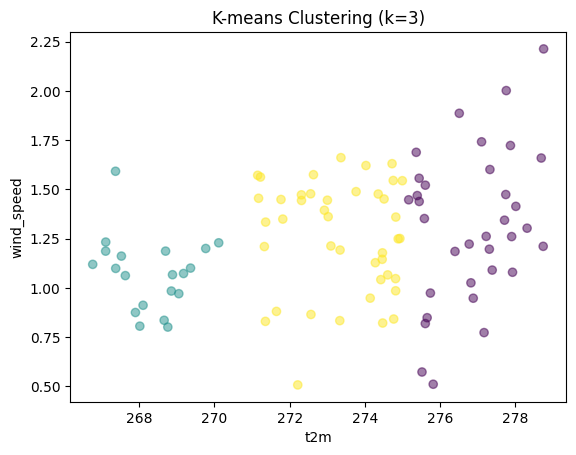

In [38]:
from sklearn.cluster import KMeans
import numpy as np
# Assuming ds is your xarray.Dataset

# Extract the relevant variables for clustering
localized_data['wind_speed'] = np.sqrt(localized_data['u10']**2 + localized_data['v10']**2)
data_for_clustering = localized_data[['t2m', 'wind_speed']]

# Convert xarray.Dataset to numpy array
data_array = data_for_clustering.to_array().values.T

# Reshape the array to 2D (time x features)
data_array_2d = data_array.reshape(data_array.shape[0], -1)

# Specify the number of clusters (k)
k = 3

# Perform K-means clustering
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(data_array_2d)

# Add cluster labels to the dataset
localized_data['cluster_labels'] = xr.DataArray(clusters, dims=['time'])


# Visualize the clusters (using only two features for simplicity)
ax = plt.subplots()
plt.scatter(localized_data['t2m'], localized_data['wind_speed'], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('t2m')
plt.ylabel('wind_speed')
plt.title(f'K-means Clustering (k={k})')
# ax.axline((0, 0), slope=0, color="red")
# ax.axline((0, 0), slope=10000000, color="blue") # high sloping is just tricky way of drawing vertical axis
plt.show()

#fig, ax = plt.subplots()

#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
# Assuming you have 't2m', 'v10', and 'clusters' columns in localized_data DataFrame
# Create a figure and a 3D axis
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
# Scatter plot in 3D
#ax.scatter(localized_data['v10'], localized_data['t2m'], localized_data['t2m'], c=clusters, cmap='viridis', alpha=0.5)
# Set labels
#ax.set_xlabel('v10')
#ax.set_ylabel('t2m')
#ax.set_zlabel('u10')  
# Set title
#ax.set_title(f'K-means Clustering (k={k})')

# Draw red and blue lines (assuming you wanted to draw lines)
#ax.axline((0, 0), slope=0, color="red")
#ax.axline((0, 0), slope=10000000, color="blue")  # high sloping is just a tricky way of drawing a vertical axis

# Show the plot
#plt.show()


#Cold and Calm Cluster:

#Cluster with low temperatures and relatively low wind speeds.
#This cluster may represent cold, calm weather conditions, possibly associated with winter or specific local climate features.
#Moderate Temperature and Moderate Wind Cluster:

#Cluster with moderate temperatures and moderate wind speeds.
#This cluster might indicate typical or transitional weather conditions with moderate temperatures and wind speeds.
#Warm and Windy Cluster:

#Cluster with higher temperatures and higher wind speeds.
#This cluster could represent warm, windy conditions, possibly associated with summer or specific regional climatic patterns.

In [40]:

# Add cluster centroids to the dataset
localized_data['cluster_centroids'] = xr.DataArray(kmeans.cluster_centers_, dims=['cluster', 'feature'])

# Predict the cluster for a new data point
new_data_point = np.array([[278, 1.8]])  # Replace with actual float values
new_data_point = new_data_point.astype(kmeans.cluster_centers_.dtype)  # Ensure consistent dtype

predicted_cluster = kmeans.predict(new_data_point)

# Display cluster centroids and predicted cluster for a new data point
print("Cluster Centroids:")
print(localized_data['cluster_centroids'].to_dataframe())

print("\nPredicted Cluster for New Data Point:")
print(f"The new data point belongs to Cluster {predicted_cluster[0]}")

Cluster Centroids:
                 cluster_centroids
cluster feature                   
0       0               276.844391
        1                 1.318307
1       0               268.312225
        1                 1.075053
2       0               273.346893
        1                 1.259938

Predicted Cluster for New Data Point:
The new data point belongs to Cluster 0
